---
title: "Homework 4 - Part 2: Tree-based Models"
subtitle: MLB Batting
date: 2025-04-19
from: markdown+emoji
execute: 
  eval: false
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [2]:
mlb_battings_2024 = pd.read_csv("https://bcdanl.github.io/data/mlb_battings_2024.csv")
mlb_battings_2024.shape

(230, 19)

In [3]:
mlb_battings_2024

,g,pa,hr,r,rbi,sb,bb_percent,k_percent,iso,babip,avg,obp,slg,w_oba,w_rc,bs_r,off,def,war
0,421,1858,157,334,350,29,17.9,25.6,0.370,0.341,0.304,0.433,0.674,0.455,202,-1.8,216.3,-16.4,27.0
1,473,2082,90,313,296,76,8.7,19.1,0.207,0.291,0.266,0.340,0.473,0.350,128,8.9,77.5,43.1,19.6
2,451,1996,132,326,320,90,12.2,23.3,0.309,0.332,0.296,0.385,0.605,0.411,168,10.6,169.9,-48.1,19.2
3,467,2076,72,329,291,45,11.3,15.6,0.206,0.347,0.314,0.399,0.520,0.391,153,4.7,136.8,-25.2,18.6
4,469,2035,82,304,285,110,6.2,17.8,0.217,0.316,0.288,0.336,0.505,0.356,128,19.3,84.4,28.9,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,412,1587,51,166,162,12,10.3,26.1,0.177,0.272,0.221,0.303,0.397,0.305,91,-2.2,-18.0,-41.9,-0.8
226,417,1603,53,159,189,13,5.5,25.1,0.158,0.300,0.247,0.289,0.405,0.300,87,-5.6,-30.8,-33.2,-1.0
227,288,1017,25,119,85,15,8.3,20.7,0.120,0.263,0.223,0.293,0.343,0.282,73,-1.3,-33.5,-18.2,-1.8
228,313,1105,36,124,133,15,6.1,24.2,0.160,0.261,0.221,0.268,0.381,0.280,75,-0.2,-32.8,-24.0,-2.1


# Regression Tree

In [4]:
# Set a random seed for reproducibility (like R's set.seed)
np.random.seed(42120532)
train, test = train_test_split(mlb_battings_2024, test_size=0.20, random_state=42120532)


Training MSE: 0.092
Test MSE: 6.154


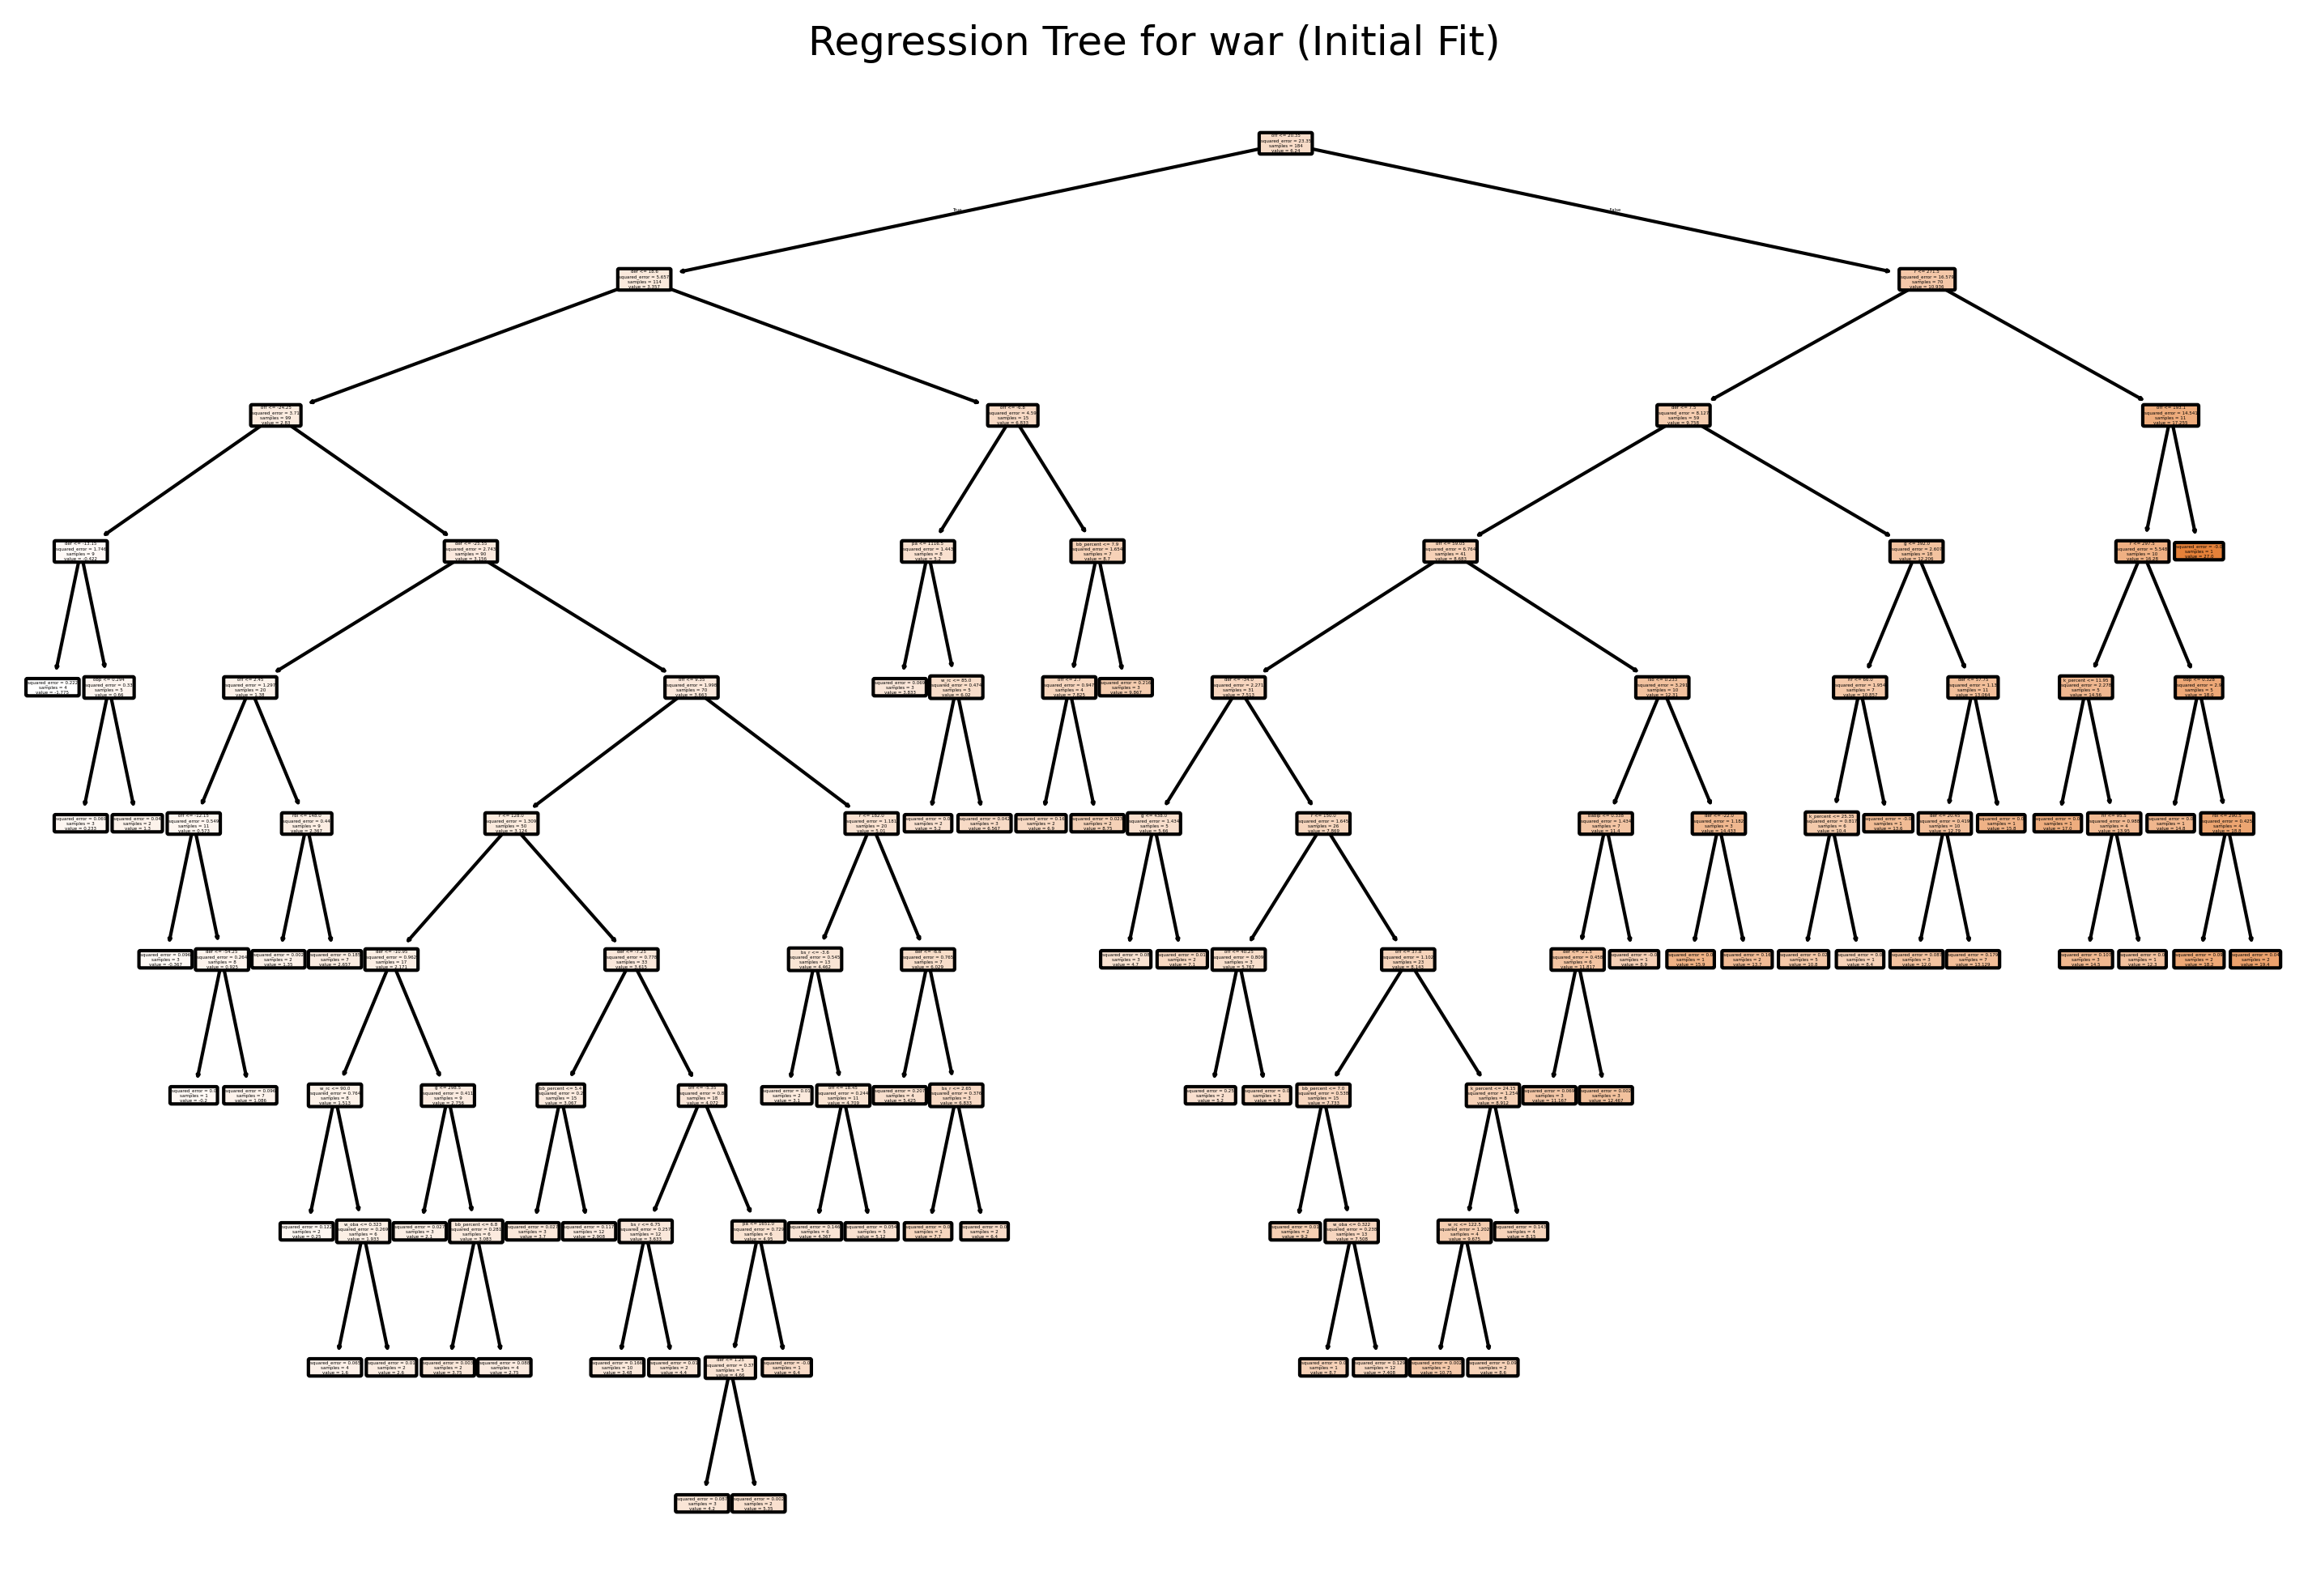

In [14]:
X_train = train.drop(columns=["war"])
y_train = train["war"]

X_test = test.drop(columns=["war"])
y_test = test["war"]

# In scikit-learn, we can use min_impurity_decrease=0.005 for a similar effect.
tree_model = DecisionTreeRegressor(min_impurity_decrease=0.005, random_state=42)
# Fit the model using all predictors (all columns except 'medv')
tree_model.fit(X_train, y_train)


# Predict on training and test sets
y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print the results
print(f"Training MSE: {mse_train:.3f}")
print(f"Test MSE: {mse_test:.3f}")

# Plot the initial regression tree
plt.figure(figsize=(12, 8), dpi = 300)
plot_tree(tree_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Regression Tree for war (Initial Fit)")
plt.show()


Training MSE: 3.61641995
Test MSE: 7.20819639


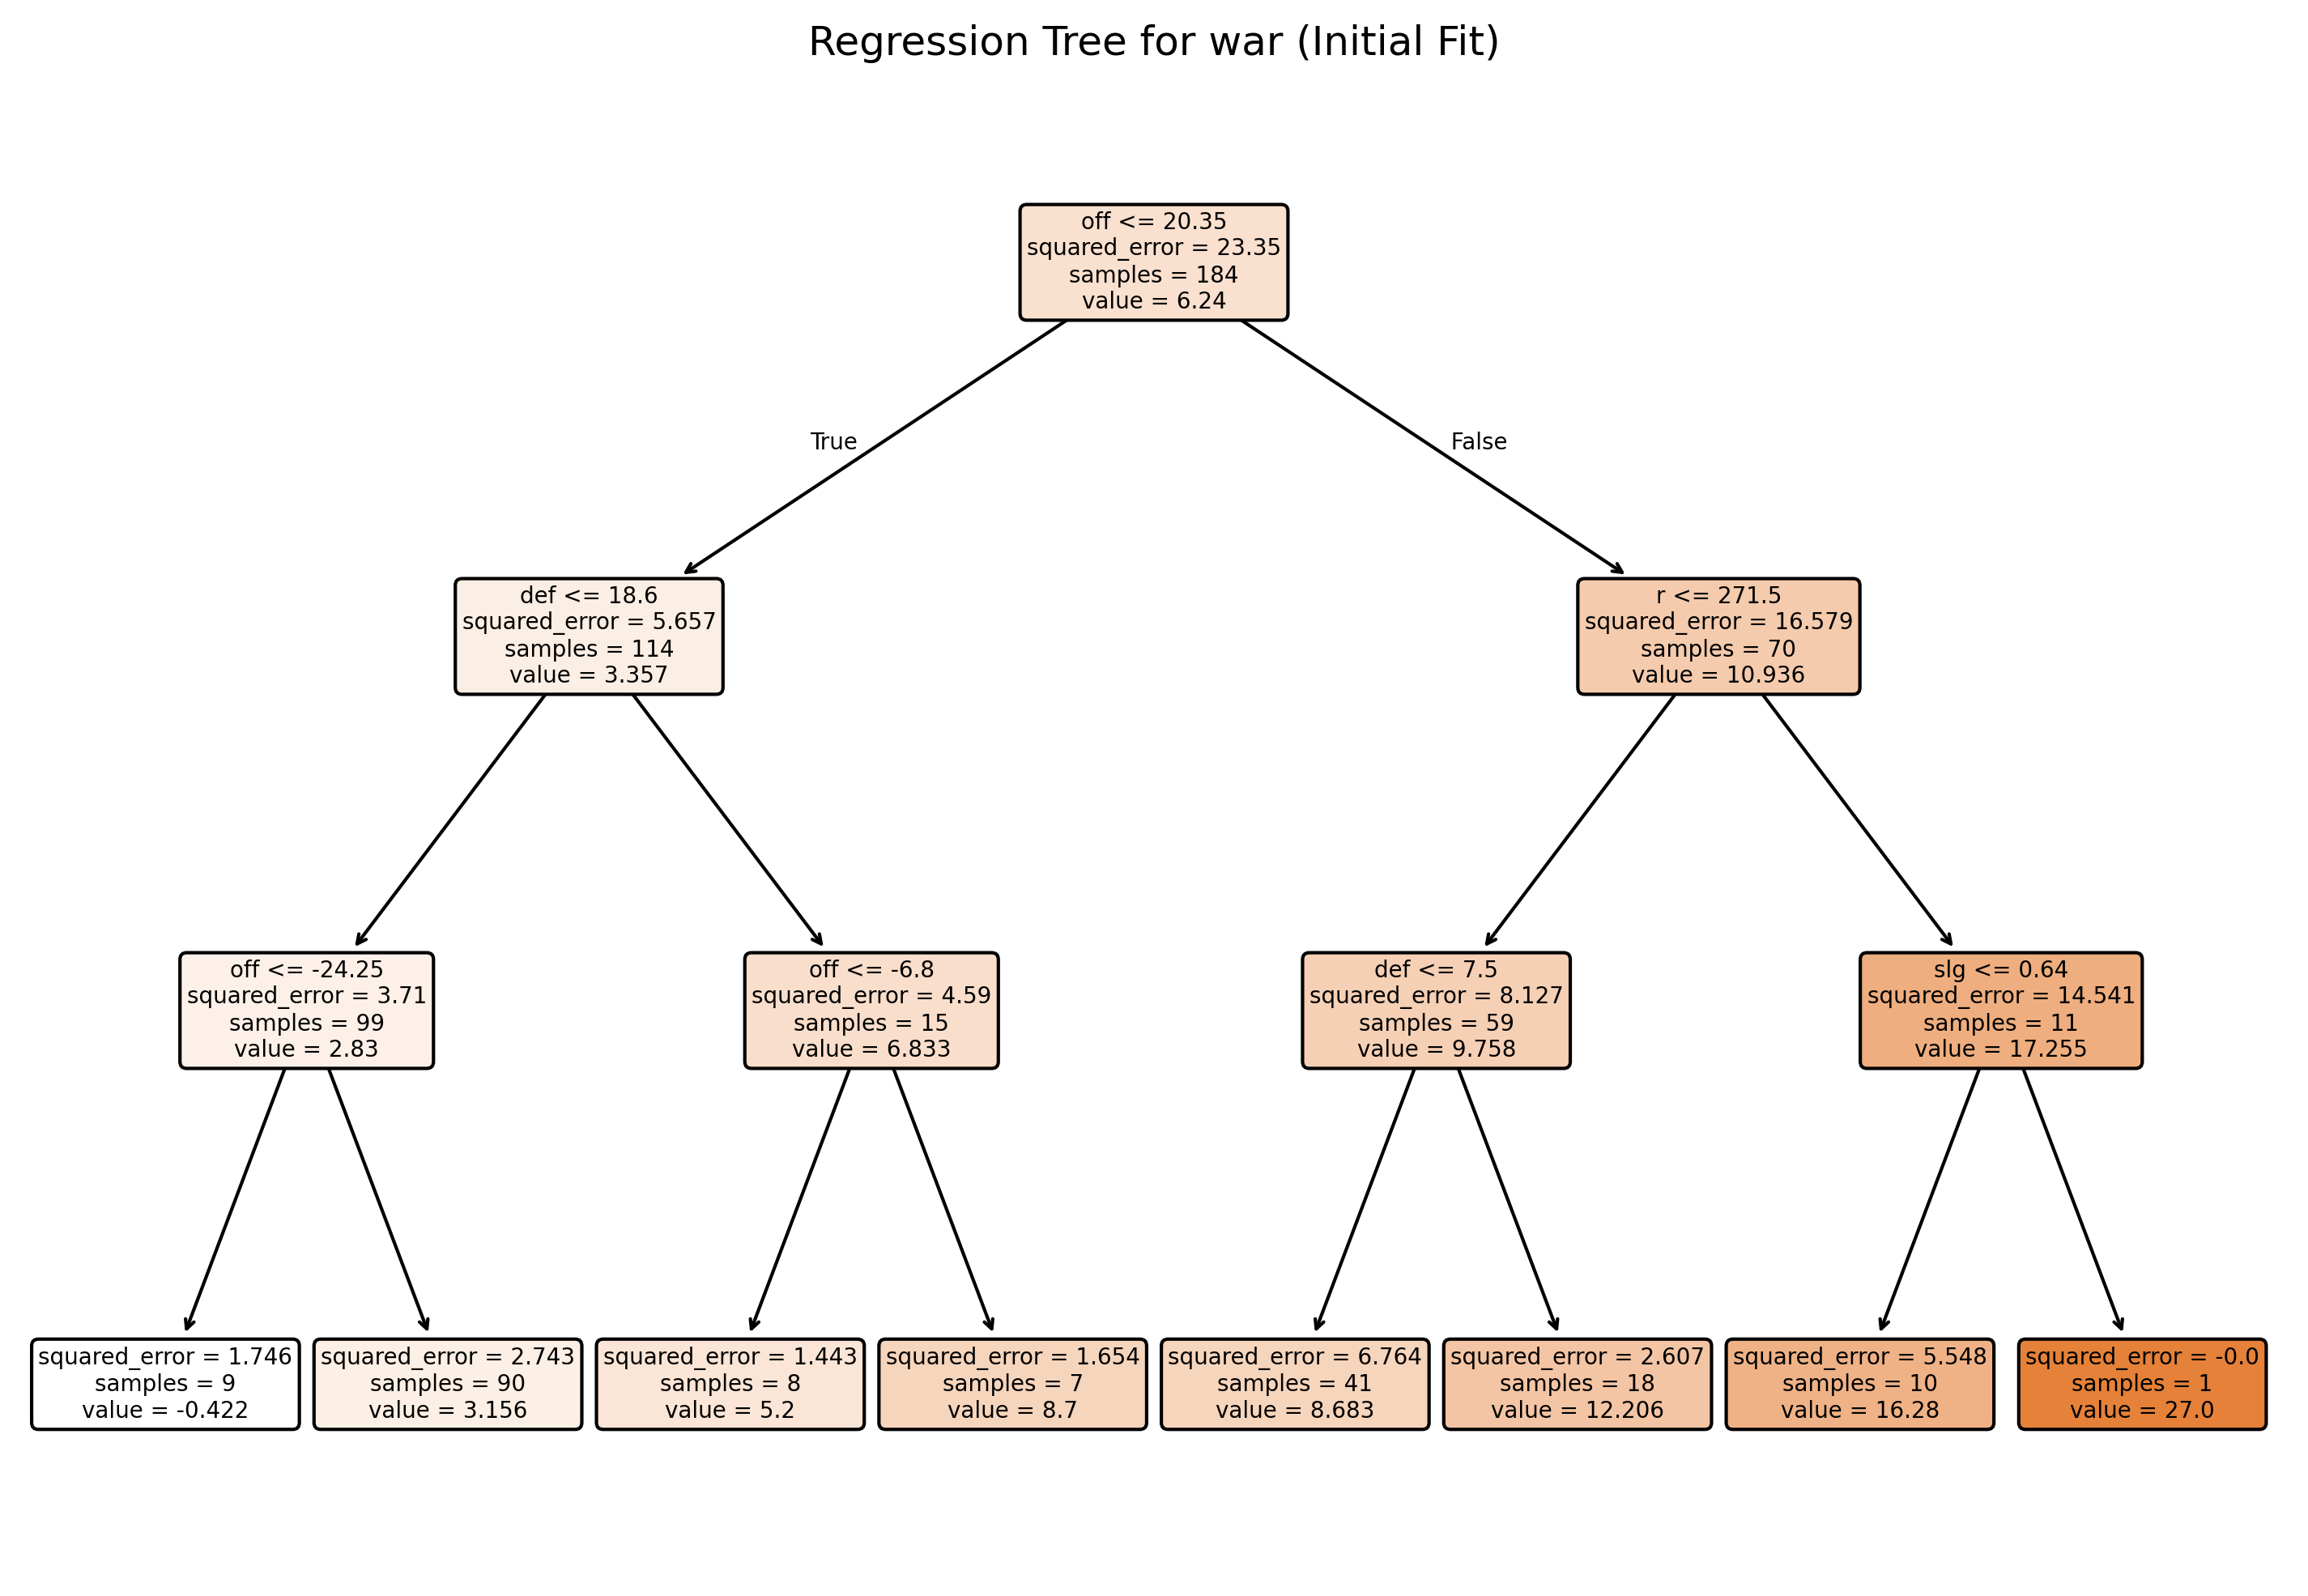

In [10]:
# In scikit-learn, we can use min_impurity_decrease=0.005 for a similar effect.
tree_model = DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.005, random_state=42)
# Fit the model using all predictors (all columns except 'medv')
tree_model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print the results
print(f"Training MSE: {mse_train:.3f}")
print(f"Test MSE: {mse_test:.3f}")

# Plot the initial regression tree
plt.figure(figsize=(12, 8), dpi = 300)
plot_tree(tree_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Regression Tree for war (Initial Fit)")
plt.show()


# Prunning

Best alpha: 0.012181159420289953
Train MSE: 0.21034767647811128
Test MSE: 5.97171015229301


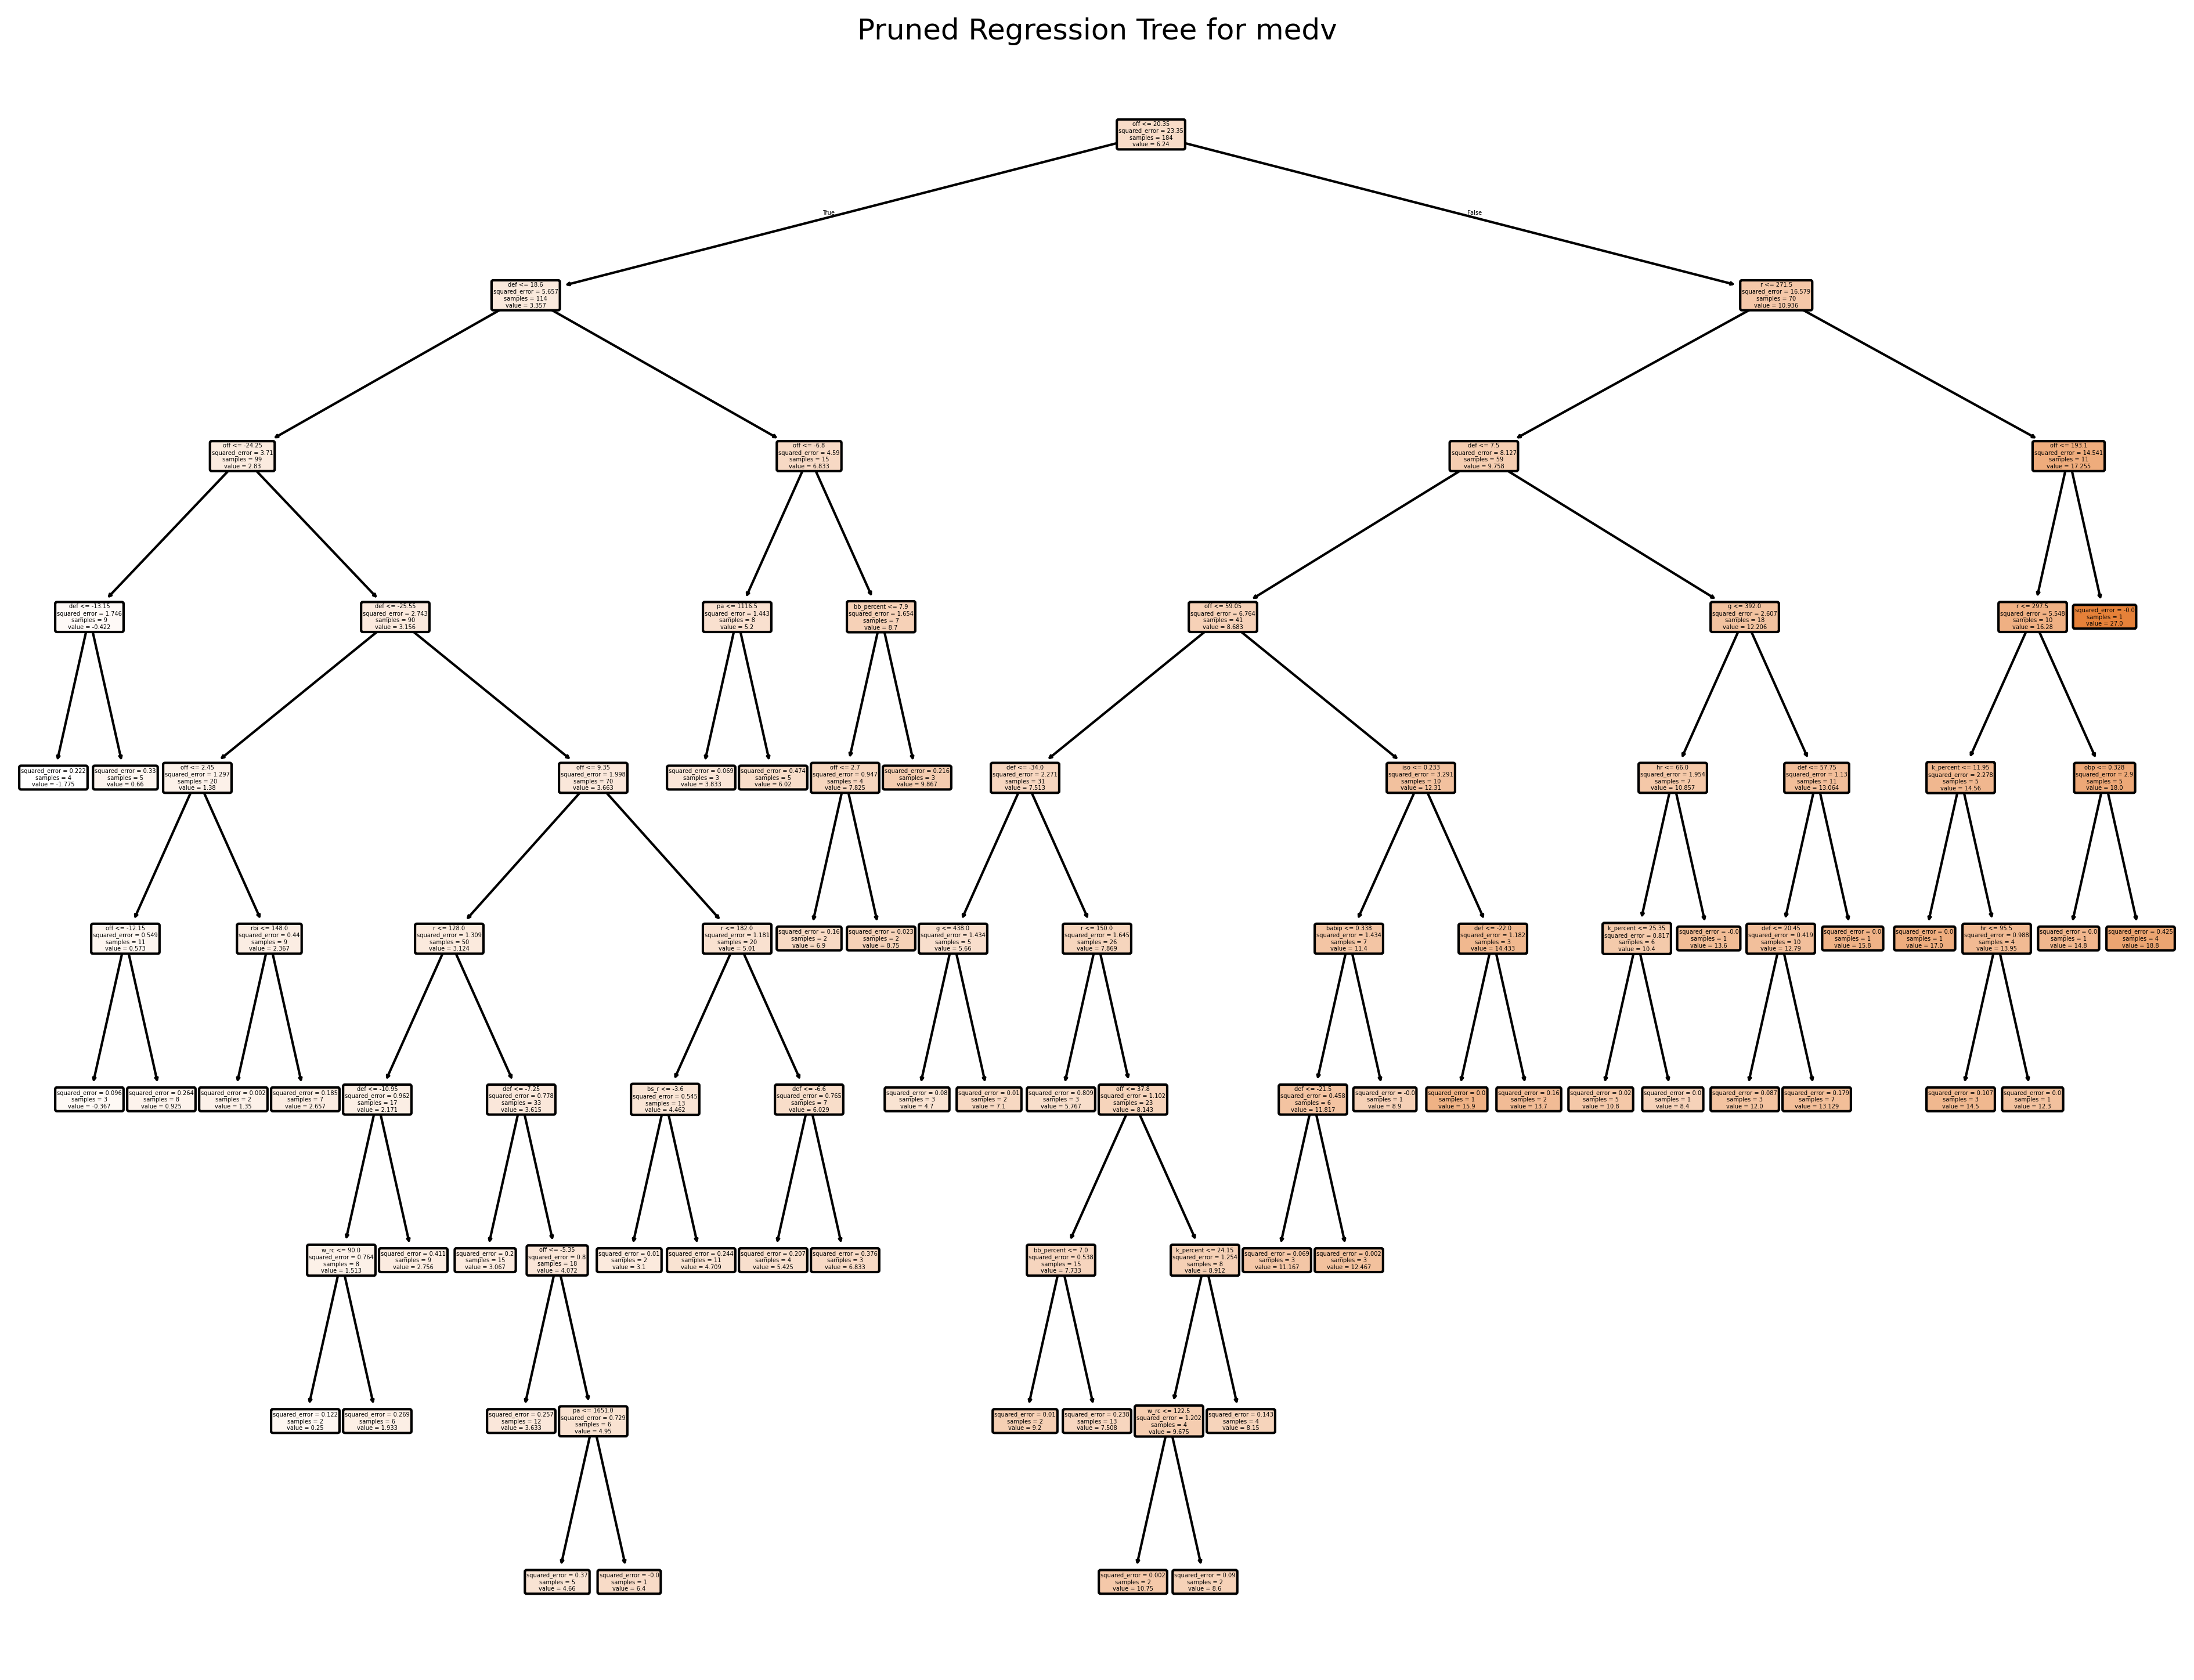

Number of leaves in the pruned tree: 47
Tree depth: 9


In [29]:
# Obtain the cost-complexity pruning path from the initial tree
path = tree_model.cost_complexity_pruning_path(X_train, y_train)  # Get candidate ccp_alpha values and corresponding impurities
ccp_alphas = path.ccp_alphas  # Candidate pruning parameters (alpha values)
impurities = path.impurities  # Impurity values at each candidate alpha

# Exclude the maximum alpha value to avoid the trivial tree (a tree with only the root)
ccp_alphas = ccp_alphas[:-1]  # Remove the last alpha value which would prune the tree to a single node

# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Initialize 10-fold CV with shuffling and fixed random state
cv_scores = []  # List to store mean cross-validated scores (negative MSE)
leaf_nodes = []  # List to record the number of leaves for each pruned tree
sse = []         # List to record the sum of squared errors (SSE) on the training set

# Loop over each candidate alpha value to evaluate its performance
for ccp_alpha in ccp_alphas:
    # Create a DecisionTreeRegressor with the current ccp_alpha and other specified parameters
    clf = DecisionTreeRegressor(random_state=42,
                                ccp_alpha=ccp_alpha,
                                min_impurity_decrease=0.005)

    # Perform 10-fold cross-validation and compute negative mean squared error (MSE)
    scores = cross_val_score(clf, X_train, y_train,
                             cv=kf, scoring="neg_mean_squared_error")
    cv_scores.append(np.mean(scores))  # Append the mean CV score for the current alpha

    # Fit the tree on the training data to record additional metrics
    clf.fit(X_train, y_train)
    leaf_nodes.append(clf.get_n_leaves())  # Record the number of leaf nodes in the tree

    # Compute SSE (sum of squared errors) on the training set
    preds = clf.predict(X_train)  # Predict target values on training data
    sse.append(np.sum((y_train - preds) ** 2))  # Calculate and record SSE for training set


# Select the best alpha based on the highest (least negative) mean CV score
best_alpha = ccp_alphas[np.argmax(cv_scores)]  # Identify the alpha with the best CV performance
print("Best alpha:", best_alpha)  # Print the best alpha value

# Train the final pruned tree using the best alpha found
final_tree = DecisionTreeRegressor(random_state=42,
                                   ccp_alpha=best_alpha,
                                   min_impurity_decrease=0.005)
final_tree.fit(X_train, y_train)  # Fit the final model on the training data

len(ccp_alphas)

preds_train = final_tree.predict(train.drop(columns=["war"]))
mse_train = mean_squared_error(y_train, preds_train)
print("Train MSE:", mse_train)

preds = final_tree.predict(test.drop(columns=["war"]))
mse = mean_squared_error(y_test, preds)
print("Test MSE:", mse)

# Plot the pruned tree.
plt.figure(figsize=(16, 12), dpi=300)
plot_tree(final_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Pruned Regression Tree for medv")
plt.show()

# Summary of the final tree
print("Number of leaves in the pruned tree:", final_tree.get_n_leaves())
print("Tree depth:", final_tree.get_depth())


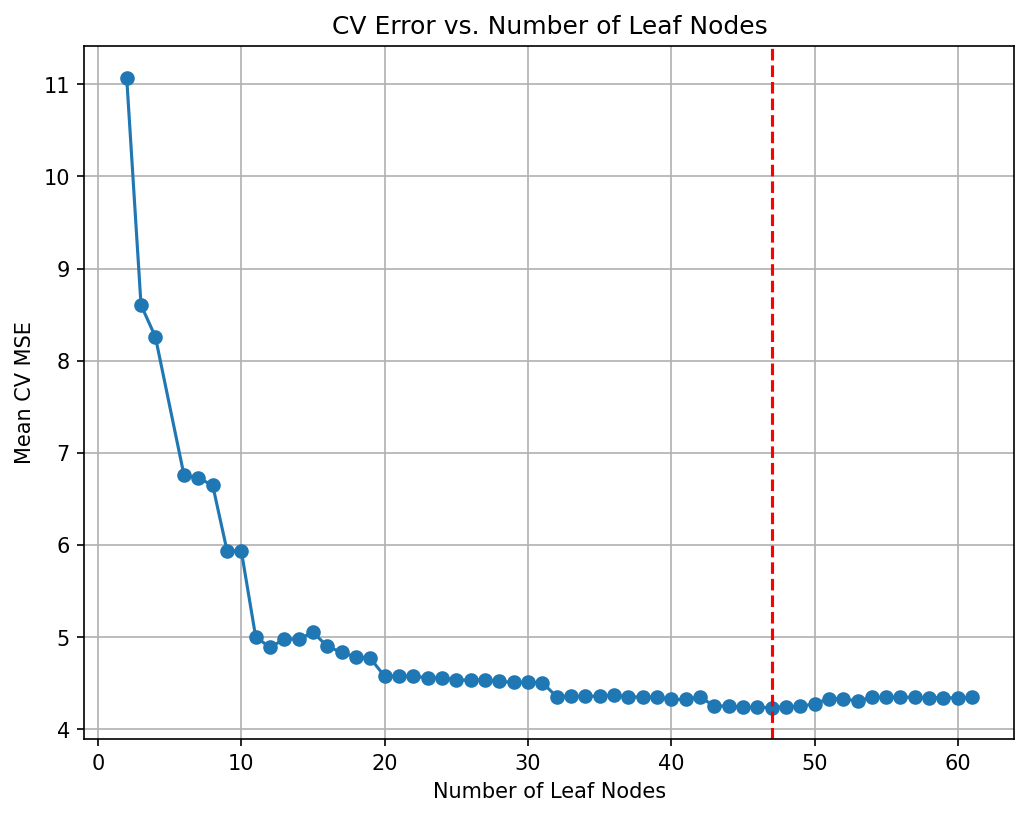

In [30]:
# Plot the average cross-validated MSE against the number of leaf nodes
negative_cv_scores = -np.array(cv_scores)

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(leaf_nodes, negative_cv_scores, marker='o', linestyle='-')
plt.axvline(x=final_tree.get_n_leaves(), color='red', linestyle='--', label='Leaf Nodes = 21')  # Add vertical line at 21 leaf nodes
plt.xlabel("Number of Leaf Nodes")
plt.ylabel("Mean CV MSE")
plt.title("CV Error vs. Number of Leaf Nodes")
plt.grid(True)
plt.show()

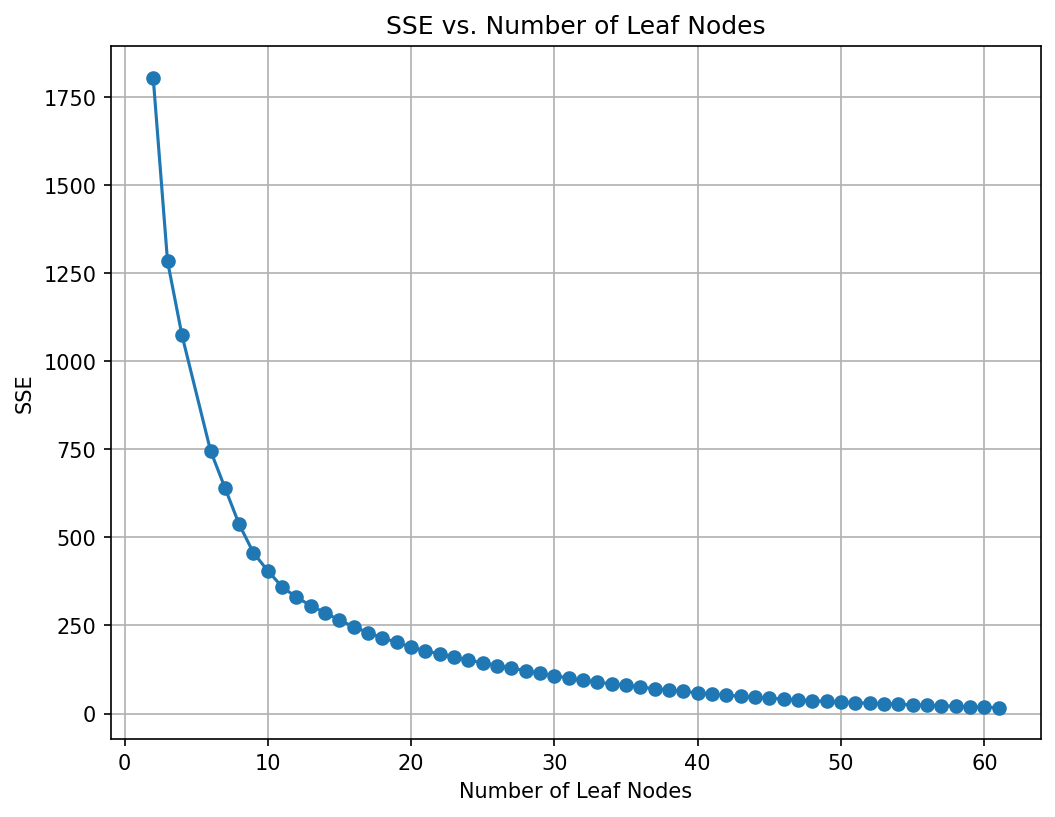

In [31]:
# Plot the SSE on the training against the number of leaf nodes
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(leaf_nodes, sse, marker='o', linestyle='-')
plt.xlabel("Number of Leaf Nodes")
plt.ylabel("SSE")
plt.title("SSE vs. Number of Leaf Nodes")
plt.grid(True)
plt.show()

# Random Forest

In [15]:
# Build the Random Forest model
# max_features=13 means that at each split the algorithm randomly considers 13 predictors.
rf = RandomForestRegressor(max_features=13,  # Use 13 features at each split
                           n_estimators=500,  # Number of trees in the forest
                           random_state=42,
                           oob_score=True)    # Use out-of-bag samples to estimate error
rf.fit(X_train, y_train)


# Print the model details
print("Random Forest Model:")
print(rf)

# Output the model details (feature importances, OOB score, etc.)
print("Out-of-bag score:", rf.oob_score_)  # A rough estimate of generalization error


# Generate predictions on training and testing sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate Mean Squared Errors (MSE) for both sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# Optional: Plot predicted vs. observed values for test data
# plt.figure(figsize=(8,6), dpi=300)
# plt.scatter(y_test, y_test_pred, alpha=0.7)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
# plt.xlabel("Observed medv")
# plt.ylabel("Predicted medv")
# plt.title("Random Forest: Observed vs. Predicted Values")
# plt.show()

Random Forest Model:
RandomForestRegressor(max_features=13, n_estimators=500, oob_score=True,
                      random_state=42)
Out-of-bag score: 0.8998284519241363
Train MSE: 0.3287167456521755
Test MSE: 3.3319365208695935


Feature Importances:
g: 0.0062
pa: 0.0164
hr: 0.0086
r: 0.2313
rbi: 0.0158
sb: 0.0076
bb_percent: 0.0059
k_percent: 0.0057
iso: 0.0049
babip: 0.0055
avg: 0.0062
obp: 0.0084
slg: 0.0087
w_oba: 0.0140
w_rc: 0.0430
bs_r: 0.0069
off: 0.5021
def: 0.1028


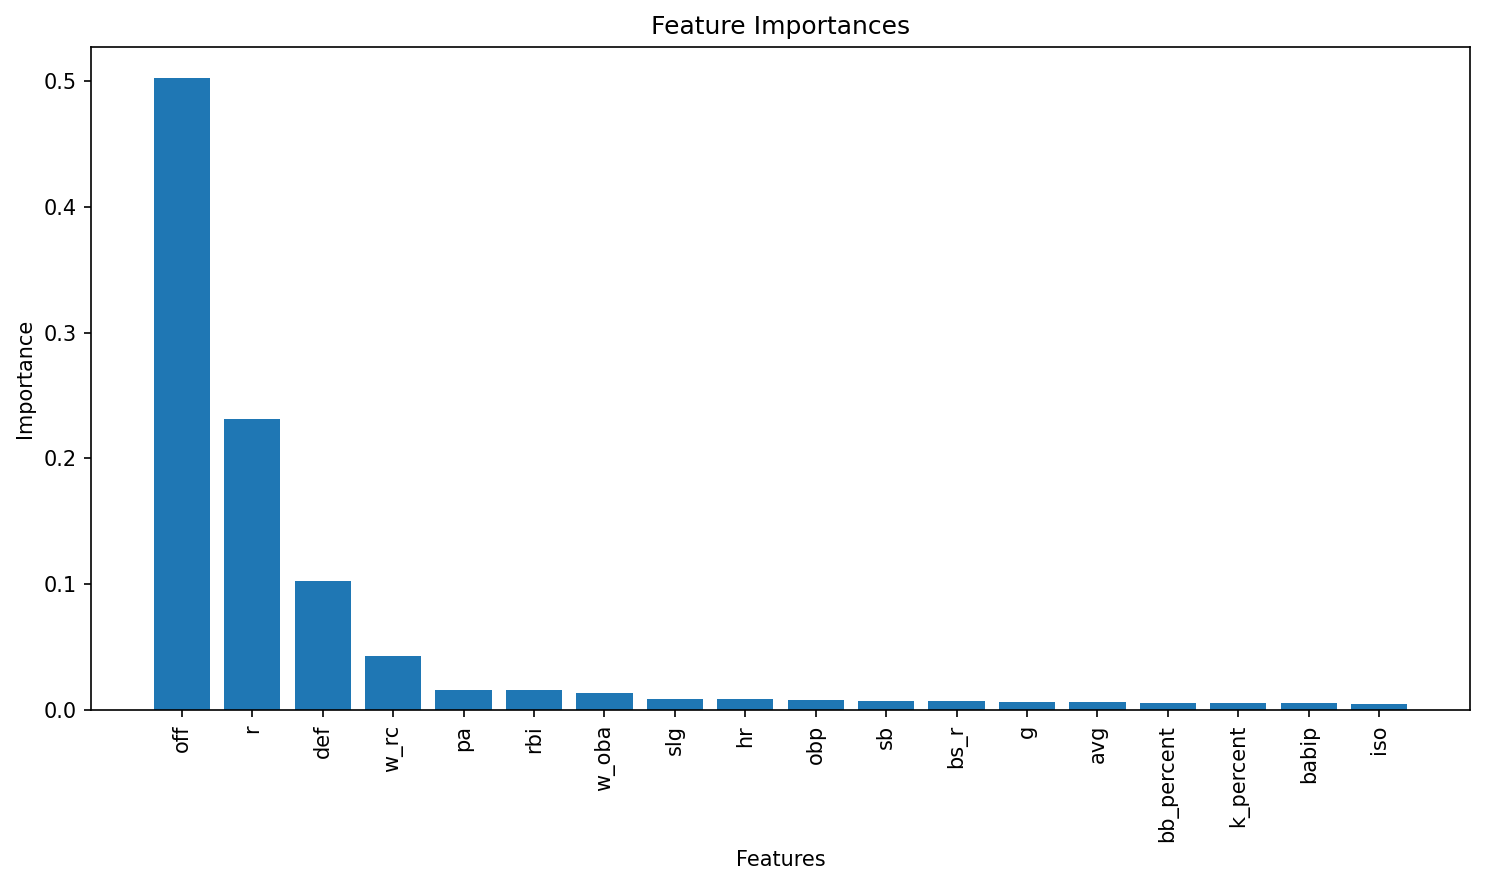

In [16]:
# Get feature importances from the model (equivalent to importance(bag.boston) in R)
importances = rf.feature_importances_
feature_names = X_train.columns

print("Feature Importances:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

# Plot the feature importances, similar to varImpPlot(bag.boston) in R
# Sort the features by importance for a nicer plot.
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6), dpi=150)
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align='center')
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# XGBoost

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


<Figure size 1000x800 with 0 Axes>

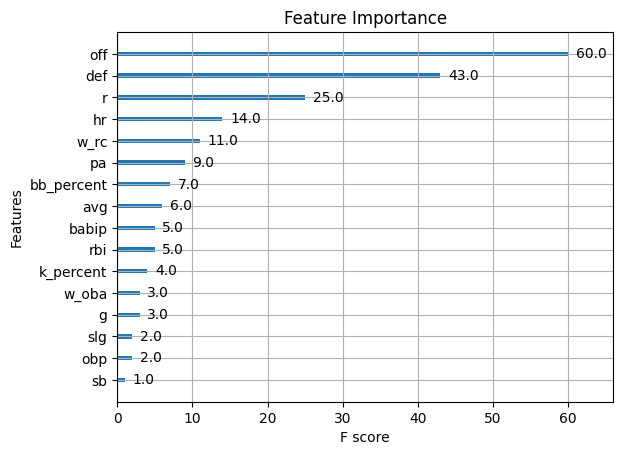

Train MSE: 0.12103999913356943
Test MSE: 0.7061771964936895
Best parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1}


In [32]:
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

# Define the grid of hyperparameters
param_grid = {
    "n_estimators": list(range(20, 201, 20)),  # nrounds: 20, 40, ..., 200
    "learning_rate": [0.025, 0.05, 0.1, 0.3],    # eta
    "gamma": [0],                               # gamma
    "max_depth": [1, 2, 3, 4],
    "colsample_bytree": [1],
    "min_child_weight": [1],
    "subsample": [1]
}

# Initialize the XGBRegressor with the regression objective and fixed random state for reproducibility
xgb_reg = XGBRegressor(objective="reg:squarederror", random_state=1937, verbosity=1)

# Set up GridSearchCV with 10-fold cross-validation; scoring is negative MSE
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    verbose=1  # Adjust verbosity as needed
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Train the final model using the best parameters (grid_search.best_estimator_ is already refit on entire data)
final_model = grid_search.best_estimator_

# Plot variable importance using XGBoost's plot_importance function
plt.figure(figsize=(10, 8))
plot_importance(final_model)
plt.title("Feature Importance")
plt.show()

# Calculate MSE on the training data
y_pred_train = final_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
print("Train MSE:", train_mse)

# Calculate MSE on the test data
y_pred = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

# Print the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

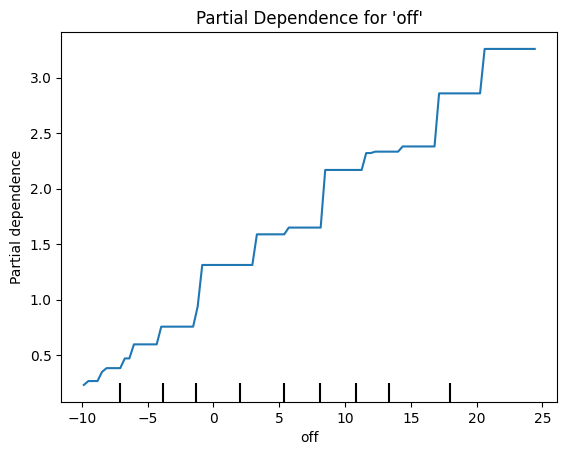

In [ ]:
# Plot partial dependence for the predictor 'off'
feature_names = mlb_battings_2024.drop(columns=["war"]).columns.tolist()
off_index = feature_names.index("off")
PartialDependenceDisplay.from_estimator(final_model, X_train, features=[off_index],
                                        feature_names=feature_names, kind="average")
plt.title("Partial Dependence for 'off'")
plt.show()

# Predictive performance and Overffiting

## Train vs. Test MSE for Tree‑Based Models

| Model                                    | Train MSE | Test MSE |
|:-----------------------------------------|----------:|---------:|
| Regression tree (no depth limit)         |     0.092 |    6.154 |
| Regression tree (max_depth = 3)          |     3.616 |    7.208 |
| CV‑pruned tree                           |     0.210 |    5.972 |
| Random forest                            |     0.329 |    3.332 |
| Gradient boosted tree                    |     0.120 |    0.706 |

---

### Predictive Performance Comparison

1. **Unrestricted Regression Tree**  
   - **Train MSE:** 0.092 (very low)  
   - **Test MSE:** 6.154 (high)  
   - **Interpretation:** Severe overfitting—model fits noise in training data but generalizes poorly.

2. **Shallow Tree (max_depth = 3)**  
   - **Train MSE:** 3.616  
   - **Test MSE:** 7.208 (highest)  
   - **Interpretation:** Underfitting—model is too simple, yielding both high training and test errors.

3. **CV‑Pruned Tree**  
   - **Train MSE:** 0.210  
   - **Test MSE:** 5.972  
   - **Interpretation:** Pruning reduces complexity relative to the unrestricted tree, lowering the gap between train and test error but still overfits somewhat.

4. **Random Forest**  
   - **Train MSE:** 0.329  
   - **Test MSE:** 3.332  
   - **Interpretation:** Bagging of many trees greatly reduces variance and overfitting compared to single trees, cutting test error by nearly half.

5. **Gradient Boosted Tree**  
   - **Train MSE:** 0.120  
   - **Test MSE:** 0.706 (lowest)  
   - **Interpretation:** Sequential boosting captures complex patterns with controlled regularization, achieving the best predictive performance and modest overfit.

---

### Overfitting Analysis

| Model                                    | Train MSE | Test MSE | Abs. Difference (Test – Train) |
|:-----------------------------------------|----------:|---------:|-------------------------------:|
| Regression tree (no depth limit)         |     0.092 |    6.154 |                         6.062 |
| Regression tree (max_depth = 3)          |     3.616 |    7.208 |                         3.592 |
| CV‑pruned tree                           |     0.210 |    5.972 |                         5.762 |
| Random forest                            |     0.329 |    3.332 |                         3.003 |
| Gradient boosted tree                    |     0.120 |    0.706 |                         0.586 |


- **Overfit severity** can be gauged by the gap between Train and Test MSE:
  - **Unrestricted tree:** gap ≈ 6.062 → very high overfit  
  - **Pruned tree:** gap ≈ 5.762 → still substantial overfit  
  - **Random forest:** gap ≈ 3.003 → moderate overfit  
  - **Gradient boosted tree:** gap ≈ 0.586 → low overfit  

- **Underfitting** is evident in the shallow tree (max_depth = 3), which shows both high train and test error.

**Overfitting Summary:**  
- **Single trees** either overfit (no limit) or underfit (too shallow).  
- **Pruning** helps but does not eliminate overfitting entirely.  
- **Ensembles** (random forest and boosting), particularly boosting, shows a minimal overfit on the test set.  